# Understanding Hodgkin-Huxley Model

###### Imports

In [153]:
# Custom Modules
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', 'modules')))
from hh_model import HodgkinHuxleyNeuron

# Standard Modules
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

###### Post-Synaptic Function

In [154]:
def I_postsyn(cur_V, par_V):
    weight = 0.1
    tau = 30
    I_syn = weight * np.exp(-(cur_V - par_V) / tau)
    return I_syn


# def I_postsyn_alt(cur_V, par_V):
    

In [155]:
# Parameters
T = 15.0
dt = 0.01
step = np.arange(0, T, dt)
# I_inp = np.full(len(step), 15.0)
# I_inp[0] = 0
# I_inp[-1] = 0

I_inp = np.zeros(len(step))
I_inp[int(0/dt):int(0.5/dt)] = 15.0
I_inp[0] = 0


# Post-Synaptic Constants
tau = 30
weight = 0.1

## Single Neuron

In [156]:
# Create neuron
neuron = HodgkinHuxleyNeuron()

# Record data
V_record = []
I_out = np.zeros(len(step))

for i, t in enumerate(step):
    neuron.step(dt, I_inp[i])
    V_record.append(neuron.V)
    I_out[i] = I_postsyn(-65.0, neuron.V)

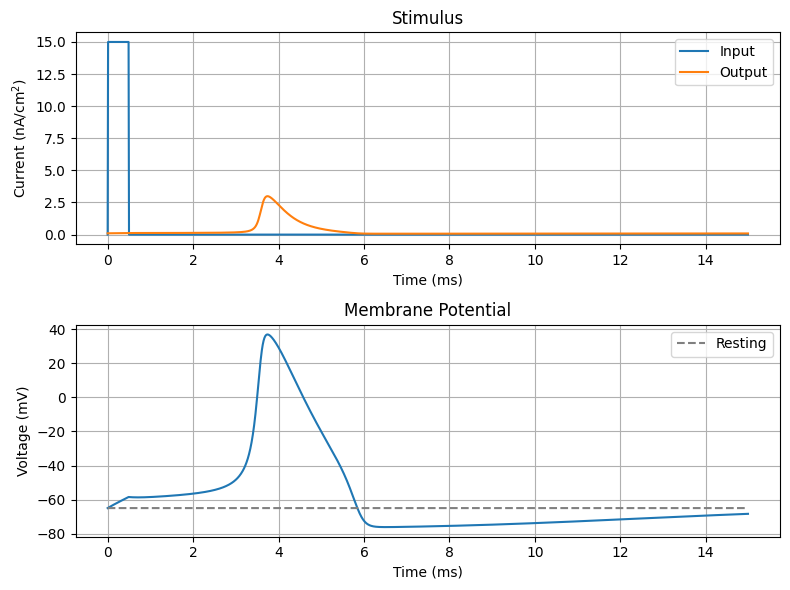

In [157]:
# Plot
plt.figure(figsize=(8, 6))

# Currents
plt.subplot(2, 1, 1)
plt.plot(step, I_inp, label='Input')
plt.plot(step, I_out, label='Output')
plt.title('Stimulus')
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA/cm$^2$)')
plt.legend()
plt.grid()

# Membrane potential V
plt.subplot(2, 1, 2)
plt.plot(step, V_record)
plt.plot(step, np.full(len(step), -65.0),
         linestyle='--', color='gray', label='Resting')
plt.title('Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Dynamics in neurons

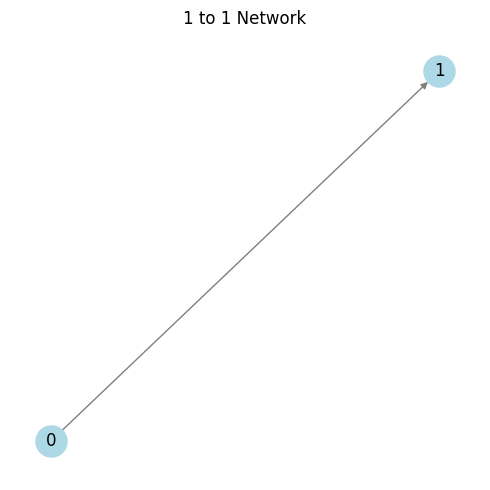

In [158]:
def create_N_to_1(N):
    network = nx.DiGraph()
    network.add_nodes_from(range(N))

    for i in range(N - 1):
        network.add_edge(i, N - 1)

    for node in network.nodes():
        network.nodes[node]['neuron'] = HodgkinHuxleyNeuron()

    return network
    

def plot_network(network, ax):
    pos = nx.spring_layout(network)
    nx.draw_networkx(network, pos, node_size=500, node_color="lightblue", edge_color="gray", arrows=True, ax=ax)
    ax.set_title(f"{len(network.nodes) - 1} to 1 Network")
    ax.axis("off")
    plt.tight_layout()


# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
Net2 = create_N_to_1(2)
plot_network(Net2, ax)

##### Simulation

In [159]:
def sim(network):
    # Record Data
    V_record = {node: [] for node in network.nodes()}
    Network = network.nodes()
    
    for i, t in enumerate(step):
        for node in Network:
            neuron = Network[node]['neuron']
            I_temp = 0.0

            if node in range(len(Network) - 1):
                neuron.step(dt, I_inp[i])
                V_record[node].append(neuron.V)
            else:
                for pred in list(network.predecessors(node)):
                    parent = Network[pred]['neuron']
                    I_temp += I_postsyn(neuron.V, parent.V)
        
                neuron.step(dt, I_temp)
                V_record[node].append(neuron.V)

    return V_record


def plot_sim(Vs, ax):
    for node, V in Vs.items():
        ax.plot(step, V, label=f'Neuron {node}')

    ax.plot(step, np.full(len(step), -65.0), linestyle='--', label='Resting', color='gray')  
    ax.set_title("Membrane Potential")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    ax.grid()
    ax.legend() 

In [160]:
Vs = sim(Net2)
# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# plot_sim(Vs, ax)

## Multiple Neurons

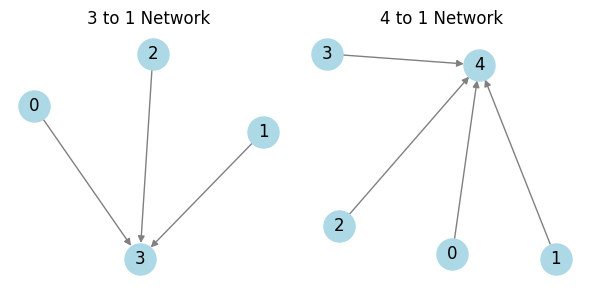

In [161]:
NetA = create_N_to_1(4)
NetB = create_N_to_1(5)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plot_network(NetA, axes[0])
plot_network(NetB, axes[1])

##### Simulation

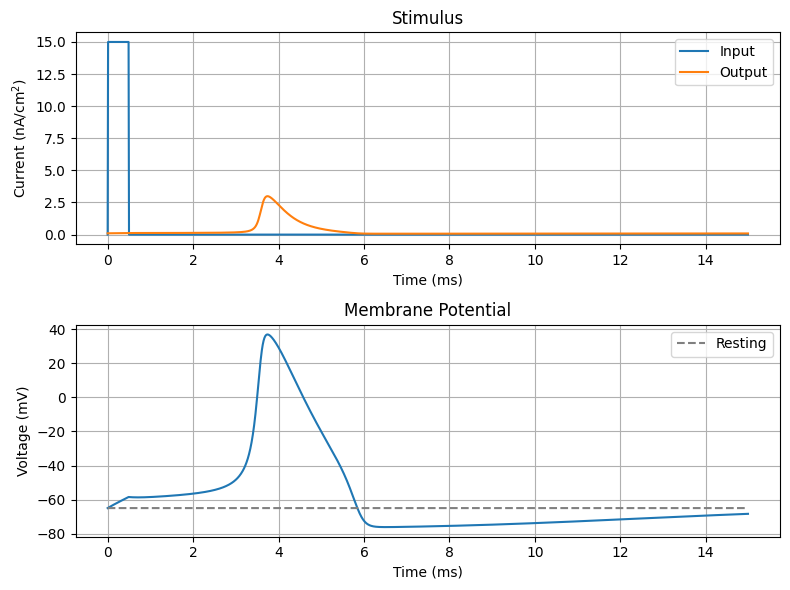

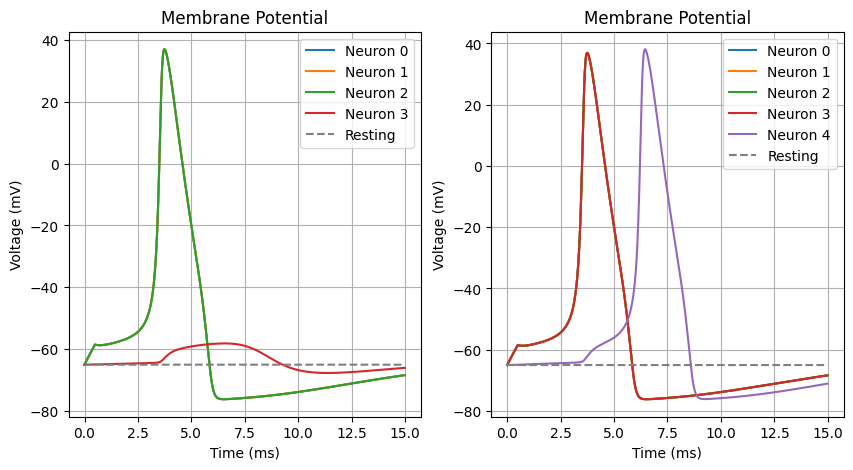

In [162]:
VsA = sim(NetA)
VsB = sim(NetB)

# Plot
plt.figure(figsize=(8, 6))

# Currents
plt.subplot(2, 1, 1)
plt.plot(step, I_inp, label='Input')
plt.plot(step, I_out, label='Output')
plt.title('Stimulus')
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA/cm$^2$)')
plt.legend()
plt.grid()

# Membrane potential V
plt.subplot(2, 1, 2)
plt.plot(step, V_record)
plt.plot(step, np.full(len(step), -65.0),
         linestyle='--', color='gray', label='Resting')
plt.title('Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_sim(VsA, axes[0])
plot_sim(VsB, axes[1])

##### Cycles

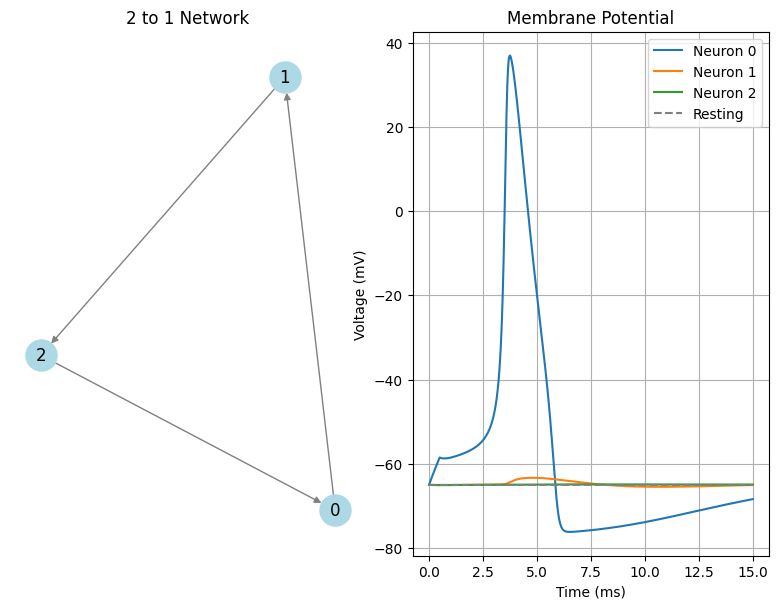

In [165]:
network = nx.DiGraph()
network.add_nodes_from(range(3))

network.add_edge(0, 1)
network.add_edge(1, 2)
network.add_edge(2, 0)

for node in network.nodes():
    network.nodes[node]['neuron'] = HodgkinHuxleyNeuron()

fig, axes = plt.subplots(1, 2, figsize=(8, 6))



V_record = {node: [] for node in network.nodes()}
Network = network.nodes()

for i, t in enumerate(step):
    for node in Network:
        neuron = Network[node]['neuron']
        I_temp = 0.0

        if node == 0:
            neuron.step(dt, I_inp[i])
            V_record[node].append(neuron.V)
        else:
            for pred in list(network.predecessors(node)):
                parent = Network[pred]['neuron']
                I_temp += I_postsyn(neuron.V, parent.V)
    
            neuron.step(dt, I_temp)
            V_record[node].append(neuron.V)


plot_network(network, axes[0])
plot_sim(V_record, axes[1])

##